In [1]:
# %pip install --quiet netket

In [2]:
import netket
from flax.core.scope import CollectionFilter
from netket.utils.types import PyTree
from netket.operator import Squared
from functools import partial, lru_cache
from typing import Callable, Optional

import jax
from jax import numpy as jnp
from flax.core.scope import CollectionFilter, DenyList  # noqa: F401

import netket as nk
from netket import jax as nkjax
from netket.operator import DiscreteOperator, Squared
from netket.stats import Stats
from netket.utils.types import PyTree
from netket.utils.dispatch import dispatch

# from nektet.vqs import _ex
from netket.vqs import expect_and_grad, expect_and_forces
from netket.vqs.mc.common import force_to_grad
from netket.stats import Stats
import time
import json
import matplotlib.pyplot as plt
import numpy as np
from netket.operator.spin import sigmax, sigmay,sigmaz

In [3]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero
# Define a 1d chain
L = 10
dis = 1
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
# ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
b=dis
a=-dis
Gamma = (b-a) * np.random.random_sample(L) + a

################################################################################
################################################################################
################################################################################
#이렇게 정의하는게 더 빨랑
ha = sum([ sigmax(hi,i)*sigmax(hi,(i+1)%L)
         + sigmay(hi,i)*sigmay(hi,(i+1)%L)
         + sigmaz(hi,i)*sigmaz(hi,(i+1)%L)
for i in range(L)])
################################################################################
################################################################################
################################################################################
ha = ha + sum([Gamma[i]*sigmaz(hi,i) for i in range(L)])

In [4]:
# Et = np.random.uniform(low=0, high=L, size=None)
# Et = np.random.randint(0,L, size=1)
Et = 5
# Et


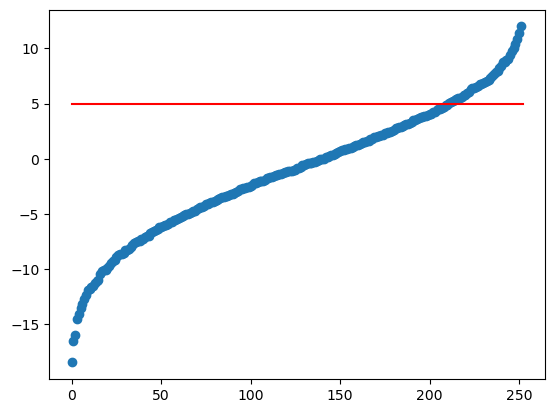

In [5]:
E, vec = np.linalg.eigh(ha.to_dense())
plt.scatter(range(len(E)),E)
plt.plot([0,len(E)],[Et,Et],'r')

In [6]:
E

array([-1.84459199e+01, -1.64836714e+01, -1.59707823e+01, -1.45224806e+01,
       -1.40632146e+01, -1.35358891e+01, -1.31755433e+01, -1.26817695e+01,
       -1.23807107e+01, -1.18631170e+01, -1.18233901e+01, -1.16377532e+01,
       -1.14815970e+01, -1.12621252e+01, -1.10783320e+01, -1.09623072e+01,
       -1.04070163e+01, -1.01368030e+01, -1.01087918e+01, -1.00698588e+01,
       -9.89812811e+00, -9.74424848e+00, -9.41829199e+00, -9.26727326e+00,
       -9.13968428e+00, -8.94101673e+00, -8.67907892e+00, -8.64387618e+00,
       -8.61675530e+00, -8.51140438e+00, -8.27016051e+00, -8.23265648e+00,
       -8.18869555e+00, -7.94732266e+00, -7.84927125e+00, -7.62286522e+00,
       -7.55672890e+00, -7.43923380e+00, -7.42539862e+00, -7.29958453e+00,
       -7.23246677e+00, -7.12428218e+00, -6.98901149e+00, -6.97763638e+00,
       -6.69251855e+00, -6.63359859e+00, -6.57558486e+00, -6.47548605e+00,
       -6.39771972e+00, -6.20008146e+00, -6.19695051e+00, -6.09812914e+00,
       -6.01785197e+00, -

In [7]:
ha_Et_inv  = np.linalg.inv((ha-Et).to_dense())
E_inv, vec_inv = np.linalg.eigh(ha_Et_inv)

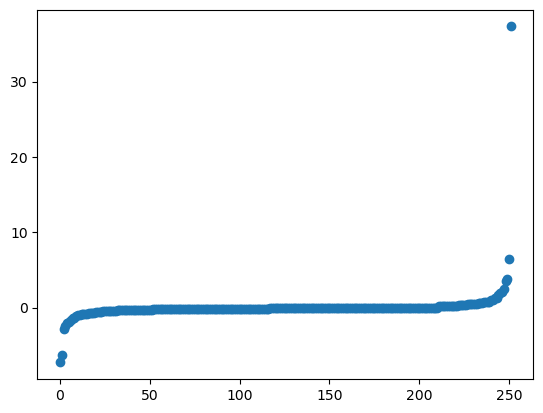

In [8]:
plt.scatter(range(len(E_inv)),E_inv)

In [9]:
E_inv
# -4.135835

array([-7.29806662, -6.24634405, -2.90207329, -2.43727604, -2.07693478,
       -1.89443848, -1.70732275, -1.37188401, -1.34961659, -1.06769772,
       -1.0293308 , -0.97474546, -0.91605138, -0.89192021, -0.83712301,
       -0.79299124, -0.76256817, -0.71483993, -0.67768184, -0.67670678,
       -0.58980174, -0.55730531, -0.54454145, -0.53216093, -0.5218322 ,
       -0.49386491, -0.47651261, -0.46906287, -0.45338319, -0.44573283,
       -0.41739522, -0.40900375, -0.39028206, -0.38773564, -0.37950087,
       -0.37111673, -0.353707  , -0.35222583, -0.34424228, -0.34032062,
       -0.33346066, -0.32807369, -0.31238638, -0.30871841, -0.29733499,
       -0.29419641, -0.28991723, -0.28394899, -0.27674599, -0.27561246,
       -0.26848575, -0.26545056, -0.25736099, -0.25238439, -0.25039881,
       -0.24968064, -0.24500479, -0.24303808, -0.23736943, -0.23679726,
       -0.23246776, -0.22755   , -0.22268876, -0.21947481, -0.21509205,
       -0.21267336, -0.21027906, -0.20801495, -0.20493054, -0.20

In [10]:
def add(x,y):
    return x+y


In [11]:
@nk.vqs.expect.dispatch
def expect_try(vstate: nk.vqs.FullSumState, Ô: nk.operator.DiscreteOperator) -> Stats:  # noqa: F811
#     _check_hilbert(vstate, Ô)

#     O = sparsify(Ô)
    O = Ô.to_sparse()
    Ψ = vstate.to_array()

    # TODO: This performs the full computation on all MPI ranks.
    # It would be great if we could split the computation among ranks.

    OΨ = O @ Ψ
    expval_O = (Ψ.conj() * OΨ).sum()

    variance = jnp.sum(jnp.abs(OΨ - expval_O * Ψ) ** 2)
    return Stats(mean=expval_O, error_of_mean=0.0, variance=variance)

In [12]:
O_sparse = ha.to_sparse()
H_Et_sparse = (ha-Et).to_sparse()
H_Et_squ_sparse = ((ha-Et)@(ha-Et)).to_sparse()

In [13]:
@expect_and_grad.dispatch
def expect_and_grad_fullsum(
    vstate: nk.vqs.FullSumState,
    Ô: nk.operator.DiscreteOperator,
    *args,
    mutable: CollectionFilter = False,
    use_covariance: Optional[bool] = None,
    **kwargs,
) -> tuple[Stats, PyTree]:
    if use_covariance is None:
        use_covariance = Ô.is_hermitian

    if use_covariance:
        # Implementation of expect_and_grad for `use_covariance == True` (due to the Literal[True]
        # type in the signature).` This case is equivalent to the composition of the
        # `expect_and_forces` and `force_to_grad` functions.
        # return expect_and_grad_from_covariance(vstate, Ô, *args, mutable=mutable)
        Ō, Ō_grad = expect_and_forces(vstate, Ô, *args, mutable=mutable, **kwargs)
        Ō_grad = force_to_grad(Ō_grad, vstate.parameters)
        return Ō, Ō_grad
    else:
        raise NotImplementedError(
            "The gradient of non hermitian operators with "
            "FullSumState is not yet implemented"
        )

@nk.vqs.expect_and_forces.dispatch
def expect_and_forces_fullsum(
    vstate: nk.vqs.FullSumState,
    Ô: nk.operator.DiscreteOperator,
    *,
    mutable: CollectionFilter = False,
) -> tuple[Stats, PyTree]:
    if isinstance(Ô, Squared):
        raise NotImplementedError("expect_and_forces not yet implemented for `Squared`")

#     _check_hilbert(vstate, Ô)


    O = O_sparse
    H_Et = H_Et_sparse
    H_Et_squ = H_Et_squ_sparse

    Ψ = vstate.to_array()
    OΨ = O @ Ψ
    H_EtΨ = H_Et@Ψ
    H_Et_squΨ = H_Et_squ @ Ψ
    Ψ_pre = H_Et @ Ψ
    Ψ_pre = Ψ_pre / jnp.linalg.norm(Ψ_pre)
    H_EtΨ_pre = H_Et @ Ψ_pre
    invOΨ = ha_Et_inv @ Ψ
    Ψ_pre_conjO = Ψ_pre.conj() @ H_Et

    expval_O, Ō_grad = _exp_forces(
        vstate._apply_fun,
        mutable,
        vstate.parameters,
        vstate.model_state,
        vstate._all_states,
        OΨ,
        Ψ,
        Ψ_pre,
        H_Et_squΨ,
        H_EtΨ,
        H_EtΨ_pre,
        invOΨ,
        Ψ_pre_conjO,
    )

    # if mutable is not False:
    #     vstate.model_state = new_model_state

    return expval_O, Ō_grad


@partial(jax.jit, static_argnums=(0, 1))
def _exp_forces(
    model_apply_fun: Callable,
    mutable: CollectionFilter,
    parameters: PyTree,
    model_state: PyTree,
    σ: jnp.ndarray,
    OΨ: jnp.ndarray,
    Ψ: jnp.ndarray,
    Ψ_pre: jnp.ndarray,
    H_Et_squΨ: jnp.ndarray,
    H_EtΨ: jnp.ndarray,
    H_EtΨ_pre: jnp.ndarray,
    invOΨ: jnp.ndarray,
    Ψ_pre_conjO: jnp.ndarray,
) -> tuple[PyTree, PyTree]:
    is_mutable = mutable is not False

    expval_O = (Ψ.conj() * invOΨ).sum()
#     expval_O = (Ψ.conj() * OΨ).sum()
    # variance = jnp.sum(jnp.abs(OΨ - expval_O * Ψ) ** 2)
    # ΔOΨ = (OΨ - expval_O * Ψ).conj() * Ψ

    expval_H_Et_squ = (Ψ.conj() * H_Et_squΨ).sum()
    ΔOΨ_squ = (H_Et_squΨ - expval_H_Et_squ * Ψ).conj() * Ψ

    denom = Ψ_pre.conj()@Ψ
    # denom = Ψ.conj()@Ψ
    expval_H_Et = (Ψ_pre.conj() * H_EtΨ).sum()/denom
    ΔOΨ_non = (Ψ_pre_conjO - expval_H_Et * Ψ_pre.conj())/denom * Ψ
#     ΔOΨ_non = (Ψ_pre_conjO - expval_H_Et * Ψ_pre.conj()) * Ψ
#     ΔOΨ_non = (H_EtΨ_pre - expval_H_Et * Ψ_pre).conj() * Ψ



    _, vjp_fun, *new_model_state = nkjax.vjp(
        lambda w: model_apply_fun({"params": w, **model_state}, σ, mutable=mutable),
        parameters,
        conjugate=True,
        has_aux=is_mutable,
    )

#     Ō_grad = vjp_fun(ΔOΨ)[0]
    Ō_grad_first = vjp_fun(ΔOΨ_squ)[0]
    Ō_grad_second = vjp_fun(-2*ΔOΨ_non)[0]

    #Let it reaches to the maximum state of inv(H-Et)
    # Ō_grad_first = vjp_fun(-ΔOΨ_squ)[0]
    # Ō_grad_second = vjp_fun(2*ΔOΨ_non)[0]
#     Ō_grad_second = vjp_fun(ΔOΨ_non)[0]

    Ō_grad = jax.tree.map(add, Ō_grad_first, Ō_grad_second)
    #######################################################
    #######################################################
    Ō_grad = Ō_grad_first
    #######################################################
    #######################################################

    # new_model_state = new_model_state[0] if is_mutable else None

    return (
        Stats(mean=expval_O, error_of_mean=0.0, variance=1.0),
        Ō_grad,
        # new_model_state,
    )

In [14]:
def variance(vsta, hamil):
    return vsta.to_array().conj()@(hamil@hamil).to_sparse()@vsta.to_array() - (vsta.to_array().conj()@(hamil).to_sparse()@vsta.to_array())**2

100%|█| 10000/10000 [13:21<00:00, 12.48it/s, Energy=3.733e+01-1.418e-16j ± 0.000


Vaiance :  0.000686329601641944
Variational result :  37.3296988252285
Real result :  -7.298066615618534


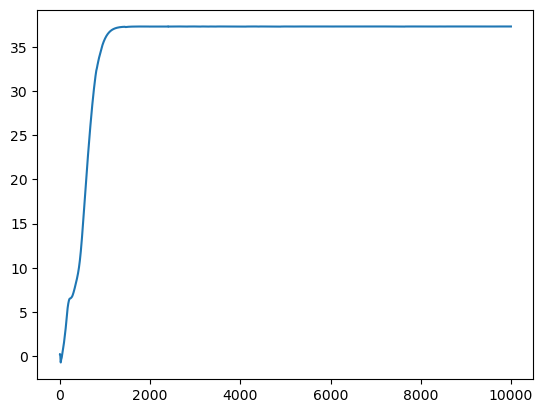

In [17]:
# Build the sampler
# sa = nk.sampler.MetropolisExchange(hilbert=hi,graph=g)
epochs = 10000

ma = nk.models.MPSPeriodic(hilbert=hi, graph=g, bond_dim=10, param_dtype=complex)
# ma = nk.models.RBM(alpha=2, param_dtype=complex)
vs = nk.vqs.FullSumState(hi, ma)

# Optimizer
# op = nk.optimizer.Sgd(learning_rate=0.001)
op = nk.optimizer.Adam(learning_rate=0.01)

# Stochastic Reconfiguration
sr = nk.optimizer.SR(diag_shift=0.1, holomorphic=True)


# The ground-state optimization loop
Target_ha = ha
gs = nk.VMC(
    hamiltonian=ha,
    optimizer=op,
    preconditioner=sr,
    variational_state=vs)

start = time.time()
gs.run(epochs, out='RBM')
end = time.time()

data=json.load(open("RBM.log"))
plt.plot(data['Energy']['Mean']['real'])
print("Vaiance : ",variance(vs, ha).real)
print("Variational result : ",data['Energy']['Mean']['real'][-1])
print("Real result : ",E_inv[0])
# plt.plot(np.log10(data['Energy']['Variance']))

In [ ]:
psi = vs.to_array()
psi.conj()@ha.to_dense()@ha.to_dense()@psi - (psi.conj()@ha.to_dense()@psi)**2

In [ ]:
psi.conj()@(hamil@hamil).to_sparse()@psi - psi.conj()@(hamil).to_sparse()@psi)**2

In [ ]:
#Austria